## Fraud Analytics Project 1 - Anomaly Detection in NY Property Data

In [1]:
## Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [2]:
## Import dataset
mydata = pd.read_csv('NY property data.csv')

### Data Cleaning & 45 Expert Variables Creation

In [3]:
## Get 3 interested fields
V1 = mydata.FULLVAL
V2 = mydata.AVLAND
V3 = mydata.AVTOT

## Create 3 sizes
S1 = mydata.LTFRONT.mul(mydata.LTDEPTH)
S2 = mydata.BLDFRONT.mul(mydata.BLDDEPTH)
S3 = S2.mul(mydata.STORIES)

## Get 9 ratios that are normalized by the 3 sizes
r1 = V1.div(S1)
r2 = V1.div(S2)
r3 = V1.div(S3)
r4 = V2.div(S1)
r5 = V2.div(S2)
r6 = V2.div(S3)
r7 = V3.div(S1)
r8 = V3.div(S2)
r9 = V3.div(S3)

In [4]:
## Put 9 ratios into the dataset
mydata['r1'] = r1
mydata['r2'] = r2
mydata['r3'] = r3
mydata['r4'] = r4
mydata['r5'] = r5
mydata['r6'] = r6
mydata['r7'] = r7
mydata['r8'] = r8
mydata['r9'] = r9

In [5]:
## Fill missing values of field ZIP with the median value of all the records in the same borough code
mydata['ZIP'] = mydata.groupby(['B'])['ZIP'].transform(lambda x: x.fillna(x.median()))

## Create groups zip5 and zip3
mydata['zip5'] = mydata.ZIP
mydata['zip3'] = mydata.ZIP // 100

In [6]:
## Only keep 4 groups and 9 ratios
mydata = mydata[['zip5', 'zip3', 'TAXCLASS', 'B', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9']]

In [7]:
## Convert positive and negative infinity and zero values to NaN
mydata = mydata.replace([np.inf, -np.inf, 0], np.nan)

## Create two lists
ratios = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9']
groups4 = ['zip5', 'zip3', 'TAXCLASS', 'B']

## Fill NaN with the average value of all the records in the same borough code
for i in ratios:
    mydata[i] = mydata[i].fillna(mydata.groupby('B')[i].transform('mean'))

In [8]:
## Create 45 variables (9 ratios grouped by 5 groups)
for i in ratios:
    for j in groups4:
        mydata[i + '/' + j] = mydata.groupby(j)[i].apply(lambda x: x / (x.mean()))
        
for i in ratios:
    mydata[i + '/all'] = mydata[i].div(mydata[i].mean())

In [9]:
## Only keep 45 fields
mydata = mydata.drop(['zip5', 'zip3', 'TAXCLASS', 'B', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9'], axis = 1)

## Reorder 45 fields
mydata = mydata[['r1/zip5', 'r2/zip5','r3/zip5','r4/zip5','r5/zip5','r6/zip5','r7/zip5','r8/zip5','r9/zip5', 'r1/zip3', 'r2/zip3', 'r3/zip3', 'r4/zip3', 'r5/zip3', 'r6/zip3', 'r7/zip3', 'r8/zip3', 'r9/zip3', 'r1/TAXCLASS', 'r2/TAXCLASS', 'r3/TAXCLASS', 'r4/TAXCLASS', 'r5/TAXCLASS', 'r6/TAXCLASS', 'r7/TAXCLASS', 'r8/TAXCLASS', 'r9/TAXCLASS', 'r1/B', 'r2/B', 'r3/B', 'r4/B', 'r5/B', 'r6/B', 'r7/B', 'r8/B', 'r9/B', 'r1/all', 'r2/all', 'r3/all', 'r4/all', 'r5/all', 'r6/all', 'r7/all', 'r8/all', 'r9/all']]

## Rename 45 fields
mydata = mydata.rename(columns={'r1/zip5':'zip5_fullvalue_lotarea', 'r2/zip5':'zip5_fullvalue_bldarea','r3/zip5':'zip5_fullvalue_bldvol','r4/zip5':'zip5_avland_lotarea','r5/zip5':'zip5_avland_bldarea','r6/zip5':'zip5_avland_bldvol','r7/zip5':'zip5_avtot_lotarea','r8/zip5':'zip5_avtot_bldarea','r9/zip5':'zip5_avtot_bldvol', 'r1/zip3':'zip3_fullvalue_lotarea', 'r2/zip3':'zip3_fullvalue_bldarea', 'r3/zip3':'zip3_fullvalue_bldvol', 'r4/zip3':'zip3_avland_lotarea', 'r5/zip3':'zip3_avland_bldarea', 'r6/zip3':'zip3_avland_bldvol', 'r7/zip3':'zip3_avtot_lotarea', 'r8/zip3':'zip3_avtot_bldarea', 'r9/zip3':'zip3_avtot_bldvol', 'r1/TAXCLASS':'taxclass_fullvalue_lotarea', 'r2/TAXCLASS':'taxclass_fullvalue_bldarea', 'r3/TAXCLASS':'taxclass_fullvalue_bldvol', 'r4/TAXCLASS':'taxclass_avland_lotarea', 'r5/TAXCLASS':'taxclass_avland_bldarea', 'r6/TAXCLASS':'taxclass_avland_bldvol', 'r7/TAXCLASS':'taxclass_avtot_lotarea', 'r8/TAXCLASS':'taxclass_avtot_bldarea', 'r9/TAXCLASS':'taxclass_avtot_bldvol', 'r1/B':'boro_fullvalue_lotarea', 'r2/B':'boro_fullvalue_bldarea', 'r3/B':'boro_fullvalue_bldvol', 'r4/B':'boro_avland_lotarea', 'r5/B':'boro_avland_bldarea', 'r6/B':'boro_avland_bldvol', 'r7/B':'boro_avtot_lotarea', 'r8/B':'boro_avtot_bldarea', 'r9/B':'boro_avtot_bldvol', 'r1/all':'all_fullvalue_lotarea', 'r2/all':'all_fullvalue_bldarea', 'r3/all':'all_fullvalue_bldvol', 'r4/all':'all_avland_lotarea', 'r5/all':'all_avland_bldarea', 'r6/all':'all_avland_bldvol', 'r7/all':'all_avtot_lotarea', 'r8/all':'all_avtot_bldarea', 'r9/all':'all_avtot_bldvol'})

In [10]:
## Glimpse of data
mydata.head()

,zip5_fullvalue_lotarea,zip5_fullvalue_bldarea,zip5_fullvalue_bldvol,zip5_avland_lotarea,zip5_avland_bldarea,zip5_avland_bldvol,zip5_avtot_lotarea,zip5_avtot_bldarea,zip5_avtot_bldvol,zip3_fullvalue_lotarea,...,boro_avtot_bldvol,all_fullvalue_lotarea,all_fullvalue_bldarea,all_fullvalue_bldvol,all_avland_lotarea,all_avland_bldarea,all_avland_bldvol,all_avtot_lotarea,all_avtot_bldarea,all_avtot_bldvol
0,0.047215,1.437584,1.279862,0.082872,0.953269,0.745024,0.073516,1.081070,0.919487,0.052713,...,1.000000,0.145673,1.679730,1.051927,0.508364,3.004347,2.529446,0.470915,3.394861,2.407828
1,0.898611,1.437584,1.279862,0.753317,0.953269,0.745024,0.762610,1.081070,0.919487,1.003242,...,1.000000,2.772472,1.679730,1.051927,4.621078,3.004347,2.529446,4.884984,3.394861,2.407828
2,0.302089,0.303114,0.326544,1.000618,0.697431,0.445563,0.470363,0.432956,0.441935,0.337263,...,0.480633,0.932032,0.354170,0.268389,6.138102,2.198041,1.512738,3.012962,1.359604,1.157281
3,0.103522,0.969078,1.565976,0.358113,2.328664,2.231545,0.161187,1.384192,2.119348,0.115576,...,2.304925,0.319395,1.132308,1.287086,2.196774,7.339074,7.576360,1.032504,4.346750,5.549864
4,0.772052,62.147801,200.854811,3.050873,170.594549,326.959463,1.202111,88.769462,271.831348,0.861947,...,295.633768,2.382001,72.615925,165.083896,18.714993,537.649807,1110.066137,7.700252,278.760947,711.835389


In [11]:
## Stats description of each column
mydata.describe()

,zip5_fullvalue_lotarea,zip5_fullvalue_bldarea,zip5_fullvalue_bldvol,zip5_avland_lotarea,zip5_avland_bldarea,zip5_avland_bldvol,zip5_avtot_lotarea,zip5_avtot_bldarea,zip5_avtot_bldvol,zip3_fullvalue_lotarea,...,boro_avtot_bldvol,all_fullvalue_lotarea,all_fullvalue_bldarea,all_fullvalue_bldvol,all_avland_lotarea,all_avland_bldarea,all_avland_bldvol,all_avtot_lotarea,all_avtot_bldarea,all_avtot_bldvol
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,...,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,3.078524e+00,6.963964e+00,7.287393e+00,9.125069e+00,1.770851e+01,1.766276e+01,6.501636e+00,1.451254e+01,1.429825e+01,6.412729e+00,...,4.286119e+01,3.579221e+00,1.028679e+01,1.148309e+01,1.048144e+01,5.235898e+01,6.651575e+01,5.416204e+00,3.328618e+01,4.295710e+01
min,3.047751e-06,2.822489e-06,3.636259e-07,1.925448e-06,2.356151e-06,2.350356e-07,1.025069e-06,5.805292e-06,8.000655e-07,2.230437e-06,...,7.403896e-07,1.602064e-06,5.637656e-06,4.134373e-07,5.243445e-07,7.250571e-06,4.829030e-07,2.131261e-07,2.164213e-05,1.782731e-06
25%,7.281875e-01,7.302930e-01,7.005689e-01,6.162187e-01,5.177638e-01,4.340280e-01,5.295813e-01,5.300371e-01,4.839756e-01,6.891867e-01,...,4.290355e-01,4.419923e-01,6.274079e-01,6.781052e-01,2.345456e-01,3.085298e-01,3.057355e-01,1.734969e-01,2.852866e-01,3.474391e-01
50%,9.590293e-01,9.360366e-01,9.197053e-01,8.666385e-01,7.579114e-01,6.788288e-01,7.782178e-01,7.472676e-01,6.951125e-01,9.781068e-01,...,6.161570e-01,6.556230e-01,8.341480e-01,9.435736e-01,3.745833e-01,4.308841e-01,4.393649e-01,2.731759e-01,3.868739e-01,4.841890e-01
75%,1.182540e+00,1.119848e+00,1.110801e+00,1.083735e+00,1.019615e+00,9.865412e-01,1.025511e+00,9.692938e-01,9.819834e-01,1.138530e+00,...,1.000000e+00,9.968400e-01,1.040524e+00,1.084386e+00,5.308660e-01,5.657687e-01,6.530652e-01,4.872199e-01,5.656258e-01,7.213508e-01
max,2.426020e+03,2.908347e+03,4.670536e+03,7.561753e+03,8.724510e+03,8.861371e+03,5.091536e+03,7.171322e+03,8.226917e+03,6.324198e+03,...,4.089824e+04,2.976280e+03,5.021773e+03,9.011344e+03,9.694331e+03,3.491400e+04,6.133792e+04,3.940377e+03,1.927778e+04,3.885657e+04


### Z scale (first time)

In [12]:
## Define the scaler
scaler = StandardScaler()

## Get a list of 45 field names
fieldName = mydata.columns.values.tolist()

## Z scale each field so that the mean is about 0 and standard deviation is about 1
mydataZ1 = mydata
for i in fieldName:
    mydataZ1[i] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(mydataZ1[i])))

In [13]:
## Glimpse of scaled data
mydataZ1.head()

,zip5_fullvalue_lotarea,zip5_fullvalue_bldarea,zip5_fullvalue_bldvol,zip5_avland_lotarea,zip5_avland_bldarea,zip5_avland_bldvol,zip5_avtot_lotarea,zip5_avtot_bldarea,zip5_avtot_bldvol,zip3_fullvalue_lotarea,...,boro_avtot_bldvol,all_fullvalue_lotarea,all_fullvalue_bldarea,all_fullvalue_bldvol,all_avland_lotarea,all_avland_bldarea,all_avland_bldvol,all_avtot_lotarea,all_avtot_bldarea,all_avtot_bldvol
0,-0.309494,0.062836,0.038404,-0.100506,-0.002639,-0.014436,-0.142500,0.005586,-0.005631,-0.147720,...,-1.398750e-16,-0.238691,0.066078,0.004522,-0.046905,0.038281,0.022994,-0.097686,0.071948,0.032773
1,-0.032934,0.062836,0.038404,-0.027034,-0.002639,-0.014436,-0.036512,0.005586,-0.005631,0.000506,...,-1.398750e-16,0.495212,0.066078,0.004522,0.345475,0.038281,0.022994,0.717289,0.071948,0.032773
2,-0.226703,-0.100070,-0.092414,0.000068,-0.017086,-0.031390,-0.081462,-0.039073,-0.039030,-0.103347,...,-1.211743e-02,-0.018990,-0.062782,-0.063712,0.490210,0.022881,0.007709,0.371656,0.010803,0.003661
3,-0.291204,-0.004440,0.077665,-0.070343,0.075030,0.069726,-0.129016,0.026473,0.078286,-0.137917,...,3.044539e-02,-0.190154,0.012862,0.025001,0.114180,0.121070,0.098869,0.006001,0.100545,0.105917
4,-0.074045,8.780607,27.424747,0.224752,9.577014,18.454621,0.031086,6.047838,18.941587,-0.021528,...,6.874142e+00,0.386118,6.961932,14.289178,1.690131,10.249437,16.673745,1.237076,8.344636,16.547574


In [14]:
## Check mean (close to 0) and standard deviation (close to 1)
mydataZ1.describe()

,zip5_fullvalue_lotarea,zip5_fullvalue_bldarea,zip5_fullvalue_bldvol,zip5_avland_lotarea,zip5_avland_bldarea,zip5_avland_bldvol,zip5_avtot_lotarea,zip5_avtot_bldarea,zip5_avtot_bldvol,zip3_fullvalue_lotarea,...,boro_avtot_bldvol,all_fullvalue_lotarea,all_fullvalue_bldarea,all_fullvalue_bldvol,all_avland_lotarea,all_avland_bldarea,all_avland_bldvol,all_avtot_lotarea,all_avtot_bldarea,all_avtot_bldvol
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,...,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,-2.653769e-19,-1.433035e-18,3.081026e-17,-7.287250e-17,2.103112e-18,-2.587425e-19,-6.365066e-17,1.397210e-17,4.551878e-17,-1.847023e-17,...,-9.872022e-18,-2.261011e-17,-2.728075e-17,1.390575e-17,7.005951e-18,4.654048e-18,-5.967664e-18,-1.284424e-16,5.937809e-19,5.980932e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.248302e-01,-1.435960e-01,-1.372233e-01,-1.095880e-01,-5.646993e-02,-5.661629e-02,-1.538074e-01,-6.890555e-02,-6.993863e-02,-1.559396e-01,...,-2.333112e-02,-2.793900e-01,-9.721152e-02,-8.708455e-02,-9.540673e-02,-1.909879e-02,-1.503403e-02,-1.846312e-01,-3.004186e-02,-2.327901e-02
25%,-8.829317e-02,-3.872896e-02,-4.108894e-02,-4.205792e-02,-2.723191e-02,-3.204325e-02,-7.235393e-02,-3.238324e-02,-3.609006e-02,-4.846820e-02,...,-1.332125e-02,-1.559021e-01,-3.622045e-02,-2.803208e-02,-7.302954e-02,-1.320634e-02,-1.043760e-02,-1.525983e-01,-2.147178e-02,-1.519100e-02
50%,-1.330856e-02,-9.184913e-03,-1.101830e-02,-1.461485e-02,-1.367076e-02,-1.818353e-02,-3.411177e-02,-1.741476e-02,-2.132343e-02,-3.414024e-03,...,-8.955495e-03,-9.621565e-02,-1.612281e-02,-4.913872e-03,-5.966900e-02,-1.086950e-02,-8.428611e-03,-1.341944e-01,-1.841985e-02,-1.200759e-02
75%,5.929453e-02,1.720980e-02,1.520446e-02,9.176382e-03,1.107682e-03,-7.619888e-04,3.923787e-03,-2.115837e-03,-1.260058e-03,2.160230e-02,...,-4.610693e-16,-8.828623e-04,3.939426e-03,7.348746e-03,-4.475856e-02,-8.293353e-03,-5.215832e-03,-9.467524e-02,-1.304969e-02,-6.486689e-03
max,7.877220e+02,4.174847e+02,6.407693e+02,8.285697e+02,4.926171e+02,5.016415e+02,7.829627e+02,4.940778e+02,5.753098e+02,9.860391e+02,...,9.541793e+02,8.312648e+02,4.880797e+02,7.846620e+02,9.248095e+02,6.668008e+02,9.221418e+02,7.273321e+02,5.791230e+02,9.045207e+02


### PCA

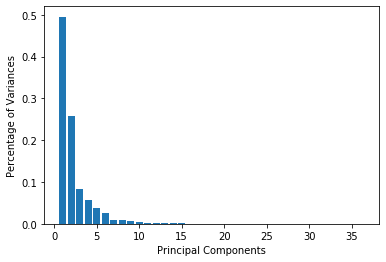

In [15]:
## First keep 45 * 80% = 36 PCs
pca = PCA(n_components = 36)

## Fit model and apply to the scaled dataset
PCs = pca.fit_transform(mydataZ1[fieldName].values)

## Get percentage of variance explained by each of the selected components
pctVarExp = pca.explained_variance_ratio_

## Draw the scree plot
x = list(range(1, 37))
plt.bar(x, pctVarExp)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Variances')
plt.show()

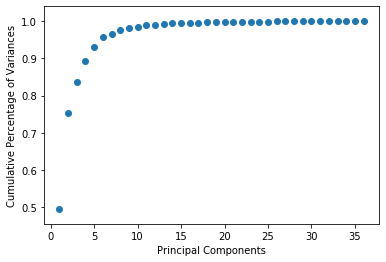

In [16]:
## Draw the cumulative explained percentage of variance
plt.scatter(x, np.cumsum(pctVarExp))
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Percentage of Variances')
plt.show()

In [17]:
## Look at the cumulative explained percentage of variance
L = list(pctVarExp)
value = 0
cumsum = []
for i in L:
    value += i
    cumsum.append("{:.4f}".format(value))
print(cumsum)

['0.4953', '0.7536', '0.8363', '0.8921', '0.9307', '0.9570', '0.9669', '0.9756', '0.9824', '0.9860', '0.9890', '0.9912', '0.9929', '0.9945', '0.9955', '0.9961', '0.9968', '0.9974', '0.9979', '0.9984', '0.9988', '0.9991', '0.9992', '0.9994', '0.9995', '0.9996', '0.9997', '0.9997', '0.9998', '0.9998', '0.9999', '0.9999', '0.9999', '0.9999', '1.0000', '1.0000']


##### Comment: Based on the above two plots and the list of cumulative explained percentage of variance, I decide to select first 6 PCs.

In [18]:
## Keep 6 PCs
pca = PCA(n_components = 6)

## Fit model and apply to the scaled dataset
PCs = pca.fit_transform(mydataZ1[fieldName].values)

## Create a dataframe with new rotated PC coordinate system
mydataPCA = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
mydataPCA.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.054224,-0.509009,0.057482,-0.198555,0.035329,-0.018583
1,0.068080,0.528172,0.066487,0.046329,0.037487,-0.035858
2,-0.182503,0.117700,-0.049415,-0.332165,-0.123167,-0.095717
3,0.199755,-0.350802,-0.062878,-0.248379,-0.083404,0.004311
4,53.063429,0.754509,-14.189022,-0.266994,8.941521,13.920991


### Z scale (second time)

In [19]:
## Define the scaler
scaler2 = StandardScaler()

## Get a list of 6 field names
fieldName2 = mydataPCA.columns.values.tolist()

## Z scale each field so that the mean is about 0 and standard deviation is about 1
mydataZ2 = mydataPCA
for i in fieldName2:
    mydataZ2[i] = pd.DataFrame(scaler2.fit_transform(pd.DataFrame(mydataZ2[i])))
mydataZ2.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.011486,-0.149293,0.029796,-0.125342,0.026792,-0.017082
1,0.014420,0.154913,0.034463,0.029246,0.028429,-0.032962
2,-0.038657,0.034522,-0.025614,-0.209686,-0.093404,-0.087987
3,0.042311,-0.102891,-0.032593,-0.156795,-0.063249,0.003962
4,11.239729,0.221299,-7.354878,-0.168545,6.780840,12.796678


In [20]:
## Check mean (close to 0) and standard deviation (close to 1)
mydataZ2.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,-2.123015e-19,5.838292e-18,2.919146e-18,-3.715277e-19,1.273809e-18,6.634423e-19
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.872073e-02,-1.420422e+01,-4.921814e+02,-6.513156e+02,-3.549015e+02,-3.514228e+02
25%,-2.137431e-02,-6.863377e-02,-1.384991e-02,-4.497255e-02,-2.498199e-02,-3.835115e-02
50%,-1.010625e-02,-3.612649e-02,-4.263232e-03,-1.111264e-02,5.821778e-04,-1.504803e-02
75%,1.045064e-03,1.367217e-02,1.010599e-02,4.634629e-02,2.156455e-02,9.207386e-03
max,7.801008e+02,6.861597e+02,5.270112e+02,6.848767e+02,4.181643e+02,3.516865e+02


### Method 1: Heuristic Function of the z scores

##### Comment: I decide to use Euclidean distance.

In [21]:
## Apply the formula of Euclidean distance
mydataZ2['zscore'] = 0
for i in fieldName2:
    mydataZ2['zscore'] += (mydataZ2[i]) ** 2
mydataZ2['zscore'] = (mydataZ2['zscore']) ** (1/2)
mydataZ2.head()

,PC1,PC2,PC3,PC4,PC5,PC6,zscore
0,0.011486,-0.149293,0.029796,-0.125342,0.026792,-0.017082,0.200071
1,0.014420,0.154913,0.034463,0.029246,0.028429,-0.032962,0.167761
2,-0.038657,0.034522,-0.025614,-0.209686,-0.093404,-0.087987,0.252540
3,0.042311,-0.102891,-0.032593,-0.156795,-0.063249,0.003962,0.205036
4,11.239729,0.221299,-7.354878,-0.168545,6.780840,12.796678,19.754440


### Method 2: Autoencoder

In [22]:
## Create autoencoder
inputData = mydataZ2[fieldName2]
inputDim = 6
input_layer = Input(shape = (inputDim,))
encoder = Dense(3, activation = 'relu')(input_layer)
encoder = Dense(3, activation = 'relu')(encoder)
decoder = Dense(inputDim, activation = 'relu')(encoder)
autoencoder = Model(inputs = input_layer, outputs = decoder)

In [23]:
## Build and train the model
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
autoencoder.fit(inputData, inputData, epochs = 1, shuffle = True, verbose=1)

Epoch 1/1
1070994/1070994 [==============================] - 87s 82us/step - loss: 0.8406 - accuracy: 0.1440


In [24]:
## Predict the input dataset
pred = autoencoder.predict(inputData)

## Save the predicted output as a dataframe
autoencoder_output = pd.DataFrame(pred, columns = ['autoPC1', 'autoPC2', 'autoPC3', 'autoPC4', 'autoPC5', 'autoPC6'])
autoencoder_output.head()

,autoPC1,autoPC2,autoPC3,autoPC4,autoPC5,autoPC6
0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.091224,0.0,0.0,0.0,0.000000
2,0.000000,0.116600,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,6.780957,0.000000,0.0,0.0,0.0,15.856041


##### Comment: I decide to use Euclidean distance as well.

In [25]:
## Get absolute difference between real data and predicted output
for i in range(6):
    mydataZ2[i + 1] = abs(mydataZ2.iloc[:, i] - autoencoder_output.iloc[:, i])
mydataZ2.head()

,PC1,PC2,PC3,PC4,PC5,PC6,zscore,1,2,3,4,5,6
0,0.011486,-0.149293,0.029796,-0.125342,0.026792,-0.017082,0.200071,0.011486,0.149293,0.029796,0.125342,0.026792,0.017082
1,0.014420,0.154913,0.034463,0.029246,0.028429,-0.032962,0.167761,0.014420,0.063690,0.034463,0.029246,0.028429,0.032962
2,-0.038657,0.034522,-0.025614,-0.209686,-0.093404,-0.087987,0.252540,0.038657,0.082078,0.025614,0.209686,0.093404,0.087987
3,0.042311,-0.102891,-0.032593,-0.156795,-0.063249,0.003962,0.205036,0.042311,0.102891,0.032593,0.156795,0.063249,0.003962
4,11.239729,0.221299,-7.354878,-0.168545,6.780840,12.796678,19.754440,4.458772,0.221299,7.354878,0.168545,6.780840,3.059363


In [26]:
## Get autoencoder fraud score
mydataZ2['autoencoderScore'] = 0
for i in range(1, 7):
    mydataZ2['autoencoderScore'] += (mydataZ2[i]) ** 2
mydataZ2['autoencoderScore'] = (mydataZ2['autoencoderScore']) ** (1/2)
mydataZ2.head()

,PC1,PC2,PC3,PC4,PC5,PC6,zscore,1,2,3,4,5,6,autoencoderScore
0,0.011486,-0.149293,0.029796,-0.125342,0.026792,-0.017082,0.200071,0.011486,0.149293,0.029796,0.125342,0.026792,0.017082,0.200071
1,0.014420,0.154913,0.034463,0.029246,0.028429,-0.032962,0.167761,0.014420,0.063690,0.034463,0.029246,0.028429,0.032962,0.090565
2,-0.038657,0.034522,-0.025614,-0.209686,-0.093404,-0.087987,0.252540,0.038657,0.082078,0.025614,0.209686,0.093404,0.087987,0.263290
3,0.042311,-0.102891,-0.032593,-0.156795,-0.063249,0.003962,0.205036,0.042311,0.102891,0.032593,0.156795,0.063249,0.003962,0.205036
4,11.239729,0.221299,-7.354878,-0.168545,6.780840,12.796678,19.754440,4.458772,0.221299,7.354878,0.168545,6.780840,3.059363,11.375049


### Final Fraud Score

In [27]:
## Use extreme quantile binning/rank ordering to scale each score
mydataZ2['zscoreRank'] = mydataZ2['zscore'].rank(ascending = True)
mydataZ2['autoencoderScoreRank'] = mydataZ2['autoencoderScore'].rank(ascending = True)

## Get combination of two above scaled scores
mydataZ2['finalScore'] = 0.4 * mydataZ2['zscoreRank'] + 0.6 * mydataZ2['autoencoderScoreRank']

## Get file key for each record
df = pd.read_csv('NY property data.csv')
mydataZ2['BBLE'] = df['BBLE']

## Get top 10 records
sortScore = mydataZ2.sort_values(by=['finalScore'], ascending=False)
newdf = sortScore.head(10)
newdf

,PC1,PC2,PC3,PC4,PC5,PC6,zscore,1,2,3,4,5,6,autoencoderScore,zscoreRank,autoencoderScoreRank,finalScore,BBLE
632815,780.100821,-14.204219,-492.181361,14.940753,-70.020614,-351.422758,989.760380,780.100821,14.204219,492.181361,14.940753,109.926791,351.422758,993.381409,1070994.0,1070994.0,1070994.0,4018420001
1067359,5.573448,684.640306,3.887163,684.876683,-40.145578,15.779062,969.378791,5.573448,684.640306,3.887163,684.876683,110.729547,15.779062,974.856197,1070993.0,1070993.0,1070993.0,5078530085
565391,6.430715,686.159711,-10.931955,-651.315647,40.068341,-33.284555,947.576602,288.277506,306.521192,111.319955,651.315647,40.068341,33.284555,785.096618,1070992.0,1070992.0,1070992.0,3085900700
585117,267.702806,-4.165780,527.011190,-13.192055,-265.987530,-325.027613,725.251189,267.702806,6.031941,527.011190,13.192055,266.056481,325.027613,725.289599,1070991.0,1070991.0,1070991.0,4004200001
585119,228.480736,-3.167638,419.498780,-20.769332,-354.901547,81.483962,601.014822,199.470633,3.167638,418.371463,20.769332,354.901547,18.597640,584.436133,1070990.0,1070990.0,1070990.0,4004200101
585438,215.760433,-2.879190,431.269699,1.142332,173.943434,-121.769154,526.915323,215.760433,4.745350,431.269699,1.142332,173.874484,121.769154,526.906068,1070989.0,1070989.0,1070989.0,4004590005
920627,133.278072,-2.071757,110.787282,13.789343,418.164266,153.581034,478.204759,35.955021,2.071757,71.754064,13.789343,418.164266,20.380182,426.512078,1070988.0,1070988.0,1070988.0,4155770029
1067000,147.698372,-2.416165,161.968827,10.497416,317.631536,32.267382,387.421889,52.727089,17.614130,137.326430,10.497416,317.631536,22.946500,351.390783,1070986.0,1070987.0,1070986.6,5078120132
794104,91.068445,-1.250938,105.054285,7.319075,235.688515,79.709998,285.110080,1.389162,1.250938,86.050666,7.319075,235.688515,3.018517,251.037782,1070983.0,1070985.0,1070984.2,4089460045
556608,14.506517,189.410005,-11.582014,-215.881017,-8.550326,39.962985,290.681086,68.632498,79.854844,39.921869,215.881017,8.550326,39.962985,246.892149,1070984.0,1070983.0,1070983.4,3083120001


(array([21421., 21420., 21420., 21439., 21400., 20865., 21974., 21421.,
        21598., 21241., 21420., 21420., 21421., 21419., 21420., 21424.,
        21414., 21421., 22799., 19997., 21464., 21420., 21408., 21622.,
        21229., 21420., 21417., 21422., 21421., 21419., 21420., 21451.,
        21389., 21420., 21996., 21528., 21175., 19725., 22675., 21420.,
        21420., 21419., 21421., 21419., 21420., 21420., 21420., 21420.,
        21420., 21420.]),
 array([1.50000000e+00, 2.14213500e+04, 4.28412000e+04, 6.42610500e+04,
        8.56809000e+04, 1.07100750e+05, 1.28520600e+05, 1.49940450e+05,
        1.71360300e+05, 1.92780150e+05, 2.14200000e+05, 2.35619850e+05,
        2.57039700e+05, 2.78459550e+05, 2.99879400e+05, 3.21299250e+05,
        3.42719100e+05, 3.64138950e+05, 3.85558800e+05, 4.06978650e+05,
        4.28398500e+05, 4.49818350e+05, 4.71238200e+05, 4.92658050e+05,
        5.14077900e+05, 5.35497750e+05, 5.56917600e+05, 5.78337450e+05,
        5.99757300e+05, 6.21177150e+05

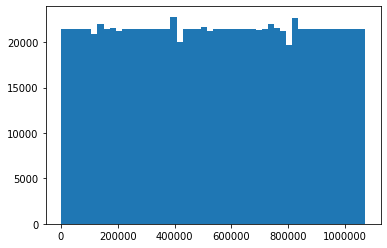

In [28]:
## plot 3 fraud score distributions
plt.hist(mydataZ2['zscoreRank'], bins = 50)

(array([21421., 21420., 21420., 21439., 21399., 20928., 21913., 21420.,
        21325., 21512., 21422., 21419., 21422., 21419., 21421., 21419.,
        21419., 21420., 21420., 21419., 20977., 21864., 21420., 21419.,
        21421., 21419., 21420., 21419., 21421., 21418., 21421., 21420.,
        21420., 21420., 21420., 21422., 21419., 21418., 21420., 21420.,
        21420., 21420., 21420., 21419., 21420., 21420., 21420., 21420.,
        21420., 21420.]),
 array([1.50000000e+00, 2.14213500e+04, 4.28412000e+04, 6.42610500e+04,
        8.56809000e+04, 1.07100750e+05, 1.28520600e+05, 1.49940450e+05,
        1.71360300e+05, 1.92780150e+05, 2.14200000e+05, 2.35619850e+05,
        2.57039700e+05, 2.78459550e+05, 2.99879400e+05, 3.21299250e+05,
        3.42719100e+05, 3.64138950e+05, 3.85558800e+05, 4.06978650e+05,
        4.28398500e+05, 4.49818350e+05, 4.71238200e+05, 4.92658050e+05,
        5.14077900e+05, 5.35497750e+05, 5.56917600e+05, 5.78337450e+05,
        5.99757300e+05, 6.21177150e+05

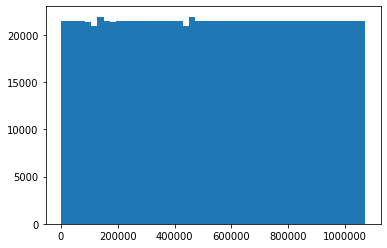

In [29]:
plt.hist(mydataZ2['autoencoderScoreRank'], bins = 50)

(array([21421., 21420., 21420., 21439., 21395., 20909., 21927., 21384.,
        21201., 21389., 20934., 21323., 20999., 15084., 11058., 15440.,
        16771., 20947., 20058., 20181., 21621., 23246., 34206., 36419.,
        33968., 21724., 23669., 24079., 24328., 24398., 21858., 20859.,
        23295., 21729., 22201., 18211., 12640., 12136., 20171., 14491.,
        23004., 28612., 20838., 19046., 21328., 22640., 20825., 21173.,
        21236., 20343.]),
 array([1.50000000e+00, 2.14213500e+04, 4.28412000e+04, 6.42610500e+04,
        8.56809000e+04, 1.07100750e+05, 1.28520600e+05, 1.49940450e+05,
        1.71360300e+05, 1.92780150e+05, 2.14200000e+05, 2.35619850e+05,
        2.57039700e+05, 2.78459550e+05, 2.99879400e+05, 3.21299250e+05,
        3.42719100e+05, 3.64138950e+05, 3.85558800e+05, 4.06978650e+05,
        4.28398500e+05, 4.49818350e+05, 4.71238200e+05, 4.92658050e+05,
        5.14077900e+05, 5.35497750e+05, 5.56917600e+05, 5.78337450e+05,
        5.99757300e+05, 6.21177150e+05

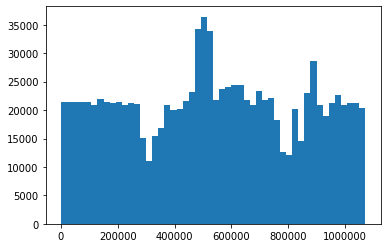

In [30]:
plt.hist(mydataZ2['finalScore'], bins = 50)

In [31]:
## Get top 10 records
pd.set_option('display.max_columns', None)
records = pd.DataFrame()
for i in range(10):
    records = records.append(df[df['BBLE'] == newdf.iloc[i]['BBLE']])
records

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
632815,632816,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,157,95,NaN,1.0,2.930000e+06,1.318500e+06,1.318500e+06,0.000000e+00,0.000000e+00,NaN,86-55 BROADWAY,11373.0,NaN,1,1,1201200.0,1201200.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1067359,1067360,5078530085,5,7853,85,NaN,NaN,B2,1,1,1,NaN,2.0,8.360000e+05,2.880000e+04,5.016000e+04,0.000000e+00,0.000000e+00,NaN,20 EMILY COURT,10307.0,NaN,36,45,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
565391,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117,108,NaN,NaN,4.326304e+09,1.946837e+09,1.946837e+09,1.946837e+09,1.946837e+09,2231.0,FLATBUSH AVENUE,NaN,X1,0,0,848484666.0,848484666.0,848484666.0,848484666.0,NaN,FINAL,2010/11,AC-TR
585117,585118,4004200001,4,420,1,NaN,NEW YORK CITY ECONOMI,O3,4,298,402,NaN,20.0,3.443400e+06,1.549530e+06,1.549530e+06,0.000000e+00,0.000000e+00,NaN,28-10 QUEENS PLAZA SOUTH,11101.0,X1,1,1,1585494.0,1585494.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
585119,585120,4004200101,4,420,101,NaN,NaN,O3,4,139,342,NaN,20.0,2.151600e+06,9.682200e+05,9.682200e+05,0.000000e+00,0.000000e+00,NaN,28 STREET,NaN,NaN,1,1,975456.0,975456.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
585438,585439,4004590005,4,459,5,NaN,11-01 43RD AVENUE REA,H9,4,94,165,NaN,10.0,3.712000e+06,2.520000e+05,1.670400e+06,0.000000e+00,1.418400e+06,1986.0,11-01 43 AVENUE,11101.0,NaN,1,1,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
920627,920628,4155770029,4,15577,29,NaN,"PLUCHENIK, YAAKOV",A1,1,91,100,NaN,2.0,1.900000e+06,9.763000e+03,7.576300e+04,0.000000e+00,0.000000e+00,NaN,7-06 ELVIRA AVENUE,11691.0,NaN,1,1,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1067000,1067001,5078120132,5,7812,132,NaN,"DRANOVSKY, VLADIMIR",A3,1,96,279,NaN,3.0,2.120000e+06,6.540100e+04,1.249100e+05,0.000000e+00,0.000000e+00,NaN,238 BEDELL AVENUE,10307.0,NaN,1,1,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
794104,794105,4089460045,4,8946,45,NaN,"HAVEN BUILDERS, INC.",B1,1,37,100,NaN,3.0,1.356000e+06,1.540800e+04,7.924800e+04,0.000000e+00,0.000000e+00,NaN,91-25 75 STREET,11421.0,NaN,1,1,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
556608,556609,3083120001,3,8312,1,NaN,PARKS AND RECREATION,Q1,4,35,50,NaN,1.0,1.360000e+08,6.075000e+07,6.120000e+07,6.075000e+07,6.120000e+07,2231.0,9006 SEAVIEW AVENUE,11236.0,X1,88,62,58590000.0,59040000.0,58590000.0,59040000.0,NaN,FINAL,2010/11,AC-TR
